In [1]:
import os 

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
torch.__version__

'2.7.1+cu126'

In [4]:
torch.cuda.is_available() 

True

In [5]:
### import archetecture of models 

from trained_models_cifar10.models.vgg_models import * 
from trained_models_cifar10.models.resnet_models import * 
from trained_models_cifar10.models.densenet_models import * 
from trained_models_cifar10.models.mobilenetv2_cifar10 import * 
from trained_models_cifar10.models.googlenet_cifar10 import * 

In [6]:
## getting the archetecture of model from models.vgg_models 
vgg19_model = VGG('VGG19')
resnet50_model = ResNet50() 
densenet169_model = DenseNet169() 
mobilenetV2_model = MobileNetV2() 
googlenet_model = GoogLeNet()  

In [7]:
trained_models_directory = "trained_models_cifar10/" 
device_name = 'cuda:2' 

vgg_19_model_file_name = "vgg19_cifar10_lr01.pth" 
resnet50_model_file_name = "resnet50_cifar10_lr01.pth" 
densenet169_model_file_name = "densenet169_cifar10_lr01.pth" 
mobilenetV2_model_file_name = "mobilenetv2_cifar10_lr01.pth" 
googlenet_model_file_name = "googlenet_cifar_lr01.pth" 

vgg19_path = os.path.join(trained_models_directory, vgg_19_model_file_name) 
resnet50_path = os.path.join(trained_models_directory, resnet50_model_file_name) 
densenet169_path = os.path.join(trained_models_directory, densenet169_model_file_name) 
mobilenetV2_path = os.path.join(trained_models_directory, mobilenetV2_model_file_name) 
googlenet_path = os.path.join(trained_models_directory, googlenet_model_file_name) 

## load the model 
vgg19_model.load_state_dict(torch.load(vgg19_path, map_location=device_name)['net'])
resnet50_model.load_state_dict(torch.load(resnet50_path, map_location=device_name)['net'])
densenet169_model.load_state_dict(torch.load(densenet169_path, map_location=device_name)['net'])
mobilenetV2_model.load_state_dict(torch.load(mobilenetV2_path, map_location=device_name)['net'])
googlenet_model.load_state_dict(torch.load(googlenet_path, map_location=device_name)['net'])

<All keys matched successfully>

In [8]:
trained_pool = [vgg19_model.eval(), 
                resnet50_model.eval(), 
                densenet169_model.eval(), 
                mobilenetV2_model.eval(), 
                googlenet_model.eval()]


model_names = [
    "VGG19",
    "ResNet50",
    "DenseNet169",
    "MobileNetV2",
    "GoogleNet"
]

### Load Dataset 

In [74]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load the full CIFAR10 test set (10,000 samples)
full_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)

# Calculate split sizes
val_size = int(0.9 * len(full_testset))  # 7000
test_size = len(full_testset) - val_size  # 3000

# Randomly split into validation and test subsets
val_set, test_set = random_split(
    full_testset, [val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Create DataLoaders
valloader = DataLoader(val_set, batch_size=100, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_set)}")

Validation samples: 9000
Test samples: 1000


### Evalaute base models 

In [64]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy


def evaluate_model_pool(model_pool, dataloader, device, model_names=None):
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(model_pool))]

    for model, name in zip(model_pool, model_names):
        loss, acc = evaluate_model(model, dataloader, device)
        print(f"{name:<15} → Accuracy: {acc:.2f}%, Loss: {loss:.4f}")


In [65]:
evaluate_model_pool(trained_pool, testloader, device_name, model_names)

VGG19           → Accuracy: 93.00%, Loss: 0.3427
ResNet50        → Accuracy: 95.00%, Loss: 0.2419
DenseNet169     → Accuracy: 95.60%, Loss: 0.2458
MobileNetV2     → Accuracy: 92.80%, Loss: 0.3225
GoogleNet       → Accuracy: 95.20%, Loss: 0.2009


### VisionDES model 

In [66]:
from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
import numpy as np
import faiss
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


import torch
import torch.nn as nn

def get_last_linear_layer(model):
    """
    Try to find the last Linear layer in the model,
    using common attribute names and fallback to scanning modules.
    """
    name = model.__class__.__name__.lower()

    # Common last layer attribute names to try (ViT, EfficientNet, etc)
    candidate_attrs = ['head', 'heads', 'classifier', 'fc', 'mlp_head']

    for attr in candidate_attrs:
        if hasattr(model, attr):
            layer = getattr(model, attr)
            # If it's directly a Linear layer
            if isinstance(layer, nn.Linear):
                return layer
            # If Sequential or Module, find last Linear inside it
            if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Module):
                # Find last Linear inside this attribute recursively
                last_linear = None
                for child in reversed(list(layer.modules())):
                    if isinstance(child, nn.Linear):
                        last_linear = child
                        break
                if last_linear is not None:
                    return last_linear

    # Fallback: scan all modules and pick the last Linear
    last_linear = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last_linear = m
    if last_linear is not None:
        return last_linear

    raise RuntimeError("No Linear layer found in model")


def get_features_before_last_linear(model, x):
    features = {}

    def find_last_linear(module):
        last_linear = None
        for m in module.modules():
            if isinstance(m, torch.nn.Linear):
                last_linear = m
        return last_linear

    last_linear = find_last_linear(model)
    if last_linear is None:
        raise RuntimeError("No Linear layer found in model")

    def hook(module, input, output):
        features['feat'] = input[0].detach()

    handle = last_linear.register_forward_hook(hook)

    model.eval()
    with torch.no_grad():
        _ = model(x)

    handle.remove()

    if 'feat' not in features:
        raise RuntimeError("Failed to capture features from last linear layer")

    return features['feat']
    

class VisionDES:
    def __init__(self, dsel_dataset, pool, resnet50_model):
        self.dsel_dataset = dsel_dataset
        self.dsel_loader = DataLoader(dsel_dataset, batch_size=32, shuffle=False)
        self.pool = pool
        self.suspected_model_votes = []

        # Use your trained ResNet50 as embedding extractor
        self.resnet50 = resnet50_model.to(device)
        self.resnet50.eval()

        # Remove classification head to get embeddings
        self.embedding_extractor = nn.Sequential(*list(self.resnet50.children())[:-1]).to(device)
        self.embedding_extractor.eval()

    
    def visualize_test_and_roc(self, test_img, roc_imgs, local_labels, class_names=None):
        def denormalize(img_tensor, mean, std):
            mean = torch.tensor(mean).view(-1, 1, 1).to(img_tensor.device)
            std = torch.tensor(std).view(-1, 1, 1).to(img_tensor.device)
            return img_tensor * std + mean
        """
        Display test image and its Region of Competence (RoC) images with labels.
        
        Args:
            test_img (torch.Tensor): Shape (C, H, W)
            roc_imgs (torch.Tensor): Shape (k, C, H, W)
            local_labels (np.ndarray): Shape (k,)
            class_names (list): Optional list of class names
        """
        mean = [0.485, 0.456, 0.406]
        std  = [0.229, 0.224, 0.225] 

        k = roc_imgs.size(0)
        ncols = min(k, 5)
        nrows = 1 + (k + ncols - 1) // ncols  # one row for test image + RoC images
    
        plt.figure(figsize=(3 * ncols, 3 * nrows))
    
        # Plot test image
        plt.subplot(nrows, ncols, 1)
        denorm_img = denormalize(test_img, mean, std).clamp(0, 1)
        img_np = TF.to_pil_image(denorm_img.cpu())
        plt.imshow(img_np)
        plt.title("Test Image")
        plt.axis("off")
    
        # Plot RoC images
        for i in range(k):
            plt.subplot(nrows, ncols, i + 2)
            denorm_img = denormalize(roc_imgs[i], mean, std).clamp(0, 1)
            img_np = TF.to_pil_image(denorm_img.cpu())
            label = local_labels[i]
            if class_names:
                label = class_names[label]
            plt.imshow(img_np)
            plt.title(f"RoC #{i+1}\nLabel: {label}")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        

    def resnet_embedder(self, images):
        """Extract embeddings from trained ResNet50."""
        with torch.no_grad():
            feats = self.embedding_extractor(images)  # [B, C, 1, 1]
            feats = feats.view(feats.size(0), -1)     # [B, C]
        return feats

    def fit(self):
        dsel_embeddings = []
        dsel_labels = []

        with torch.no_grad():
            for imgs, labels in tqdm(self.dsel_loader, desc="Extracting DSEL embeddings"):
                imgs = imgs.to(device)
                embs = self.resnet_embedder(imgs).cpu()
                dsel_embeddings.append(embs)
                dsel_labels.append(labels)

        dsel_embeddings_tensor = torch.cat(dsel_embeddings).detach().cpu()
        cls_embeddings = np.ascontiguousarray(dsel_embeddings_tensor.numpy(), dtype='float32')
        self.dsel_embeddings = cls_embeddings
        self.dsel_labels = torch.cat(dsel_labels).numpy()

        # Build FAISS index
        embedding_dim = cls_embeddings.shape[1]
        self.index = faiss.IndexFlatL2(embedding_dim)
        self.index.add(cls_embeddings)

    def get_output_size(self, model):
        """Get classifier output size."""
        if hasattr(model, 'fc'):
            return model.fc.out_features
        elif hasattr(model, 'classifier'):
            if isinstance(model.classifier, nn.Sequential):
                return model.classifier[-1].out_features
            else:
                return model.classifier.out_features
        else:
            raise AttributeError("Cannot determine output size of the model.")

    def predict_weighted_robust_feature_similarity(self, test_img, k=7, return_logits=False, explain=False):
        # 1️⃣ ResNet50 embedding for test image
        img_for_resnet = test_img.unsqueeze(0).to(device)
        with torch.no_grad():
            test_emb = self.resnet_embedder(img_for_resnet).cpu().numpy().astype('float32')

        # 2️⃣ Find RoC from FAISS
        _, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = np.array(self.dsel_labels[neighbor_idxs]).flatten()

        # 3️⃣ Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)

        competences = []
        soft_outputs = []
        feature_similarities = []

        # 4️⃣ Evaluate pool
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                correct = (preds == local_labels).sum()
                competence = correct / k
                competences.append(competence)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                feature_similarities.append(sim.item())

        # 5️⃣ Combine scores
        alpha = 1.0
        combined_scores = [c * (s / alpha) for c, s in zip(competences, feature_similarities)]

        total_score = sum(combined_scores)
        if total_score == 0:
            weights = [1.0 / len(self.pool)] * len(self.pool)
        else:
            weights = [s / total_score for s in combined_scores]

        # 6️⃣ Weighted aggregation
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)
        for prob, weight in zip(soft_outputs, weights):
            weighted_logits += weight * prob

        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        # Step 8: Optional explainability
        if explain:
            print("\nExplainability Report:")
            for idx, (clf, comp, sim, weight, prob) in enumerate(zip(self.pool, competences, feature_similarities, weights, soft_outputs)):
                pred_class = prob.argmax().item()
                conf = prob[pred_class].item()
                topk = torch.topk(prob, k=5)
                print(f"Model #{idx}: {clf.__class__.__name__}")
                print(f"  - Competence: {comp:.4f}")
                print(f"  - Feature similarity: {sim:.4f}")
                print(f"  - Combined weight: {weight:.4f}")
                print(f"  - Predicted class: {pred_class} with confidence {conf:.4f}")
                print(f"  - Top-5: {topk.indices.tolist()} → {[round(p.item(), 3) for p in topk.values]}")
                print("-" * 50)
    
            print(f"\n🧠 Final prediction: {weighted_logits.argmax().item()}")
            top5 = torch.topk(weighted_logits, k=5)
            print(f"🔝 Top-5 predictions:")
            for i in range(5):
                print(f"  - Class {top5.indices[i].item()}: {top5.values[i].item():.4f}")
    
            print("\nModel weight distribution:")
            for idx, w in enumerate(weights):
                print(f"  Model #{idx}: {w:.4f}")
            print(f"Suspected attacked model: Model #{min_sim_idx} ({self.pool[min_sim_idx].__class__.__name__})")
    
            print("\nRoC visualization:")
            self.visualize_test_and_roc(test_img.squeeze(0), roc_imgs, local_labels)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()


    def predict_weighted_robust_feature_similarity_v2(self, test_img, k=7, return_logits=False, explain=False):
        # 1️⃣ ResNet50 embedding for test image
        img_for_resnet = test_img.unsqueeze(0).to(device)
        with torch.no_grad():
            test_emb = self.resnet_embedder(img_for_resnet).cpu().numpy().astype('float32')

        # 2️⃣ Find RoC from FAISS
        _, neighbors = self.index.search(test_emb, k)
        neighbor_idxs = neighbors[0]
        local_labels = np.array(self.dsel_labels[neighbor_idxs]).flatten()

        # 3️⃣ Get RoC images
        with torch.no_grad():
            roc_imgs = torch.stack([self.dsel_dataset[idx][0] for idx in neighbor_idxs]).to(device)

        competences = []
        soft_outputs = []
        feature_similarities = []

        # 4️⃣ Evaluate pool
        for clf in self.pool:
            clf.eval()
            with torch.no_grad():
                outputs = clf(roc_imgs)
                preds = outputs.argmax(dim=1).cpu().numpy()
                # correct = (preds == local_labels).sum()
                # competence = correct / k
                probs_roc = softmax(outputs, dim=1)
                correct_probs = probs_roc[range(k), local_labels]  # probability assigned to the correct class
                competence = correct_probs.mean().item()
                
                competences.append(competence)

                logits = clf(test_img.unsqueeze(0).to(device)).squeeze(0)
                probs = softmax(logits, dim=0)
                soft_outputs.append(probs)

                # Feature similarity using ResNet embeddings
                test_feat = get_features_before_last_linear(clf, test_img.unsqueeze(0).to(device))
                roc_feats = get_features_before_last_linear(clf, roc_imgs)
                mean_feat = roc_feats.mean(dim=0, keepdim=True)

                # sim = cosine_similarity(test_feat / test_feat.norm(), mean_feat / mean_feat.norm(), dim=1)
                cos_sim = F.cosine_similarity(test_feat, mean_feat)
                euclid_sim = -torch.norm(test_feat - mean_feat, p=2)  # negative so higher is better
                sim = 0.7 * cos_sim + 0.3 * (euclid_sim / euclid_sim.abs().max())
                feature_similarities.append(sim.item())

        # 5️⃣ Combine scores
        alpha = 1.0
        combined_scores = [c * (s / alpha) for c, s in zip(competences, feature_similarities)]

        total_score = sum(combined_scores)
        if total_score == 0:
            weights = [1.0 / len(self.pool)] * len(self.pool)
        else:
            weights = [s / total_score for s in combined_scores]

        # 6️⃣ Weighted aggregation
        num_classes = self.get_output_size(self.pool[0])
        weighted_logits = torch.zeros(num_classes).to(device)
        for prob, weight in zip(soft_outputs, weights):
            weighted_logits += weight * prob

        min_sim_idx = int(np.argmin(feature_similarities))
        self.suspected_model_votes.append(min_sim_idx)

        if return_logits:
            return weighted_logits
        return weighted_logits.argmax().item()


In [67]:
des_model = VisionDES(val_set, trained_pool, resnet50_model.eval())

In [68]:
des_model.fit()

Extracting DSEL embeddings: 100%|█████████████████████████████████████| 282/282 [00:04<00:00, 67.21it/s]


In [69]:
def evaluate_des(des_model, dataloader):
    total = 0
    correct = 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing VisionDES"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # DES prediction (you can switch to robust or explainable prediction)
            preds = []
            for img in imgs:
                pred = des_model.predict_weighted_robust_feature_similarity_v2(
                    img, k=7, return_logits=False, explain=False
                )
                preds.append(pred)
            
            preds = torch.tensor(preds).to(device)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")
    return acc



In [70]:
def evaluate_des_fails(des_model, data):
    failed_indices = [] 
    
    with torch.no_grad():
        for i in tqdm(range(len(data))): 
            img, label = data[i][0].to(device), data[i][1]
            pred = des_model.predict_weighted_robust_feature_similarity(
                    img, k=7, return_logits=False, explain=False
                ) 

            if pred != label: 
                failed_indices.append(i) 
    return failed_indices

In [71]:
# =========================
# Run Test
# =========================
# Assume `vision_des` is already created & trained
test_acc = evaluate_des(des_model, testloader)

Testing VisionDES: 100%|████████████████████████████████████████████████| 10/10 [03:23<00:00, 20.40s/it]

✅ Test Accuracy: 0.9560


In [75]:
failed_samples = evaluate_des_fails(des_model, test_set)

100%|███████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.83it/s]


In [81]:
print(failed_samples) 

[0, 4, 16, 34, 56, 77, 78, 96, 97, 102, 131, 133, 151, 167, 200, 257, 299, 302, 310, 337, 372, 418, 419, 420, 532, 611, 617, 632, 641, 663, 667, 671, 688, 698, 705, 713, 734, 754, 819, 844, 926, 964]


In [82]:
len(failed_samples)

42

In [83]:
(1000- 42)/1000

0.958

True class: 0

Explainability Report:
Model #0: VGG
  - Competence: 0.7143
  - Feature similarity: 0.8213
  - Combined weight: 0.1648
  - Predicted class: 8 with confidence 0.9993
  - Top-5: [8, 0, 1, 9, 3] → [0.999, 0.0, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #1: ResNet
  - Competence: 1.0000
  - Feature similarity: 0.9708
  - Combined weight: 0.2727
  - Predicted class: 8 with confidence 0.9717
  - Top-5: [8, 0, 1, 4, 9] → [0.972, 0.028, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #2: DenseNet
  - Competence: 0.7143
  - Feature similarity: 0.9262
  - Combined weight: 0.1858
  - Predicted class: 8 with confidence 0.9942
  - Top-5: [8, 0, 9, 1, 7] → [0.994, 0.005, 0.0, 0.0, 0.0]
--------------------------------------------------
Model #3: MobileNetV2
  - Competence: 0.7143
  - Feature similarity: 0.9003
  - Combined weight: 0.1806
  - Predicted class: 8 with confidence 0.9985
  - Top-5: [8, 0, 2, 9, 1] → [0.999, 0.001, 0.0, 0

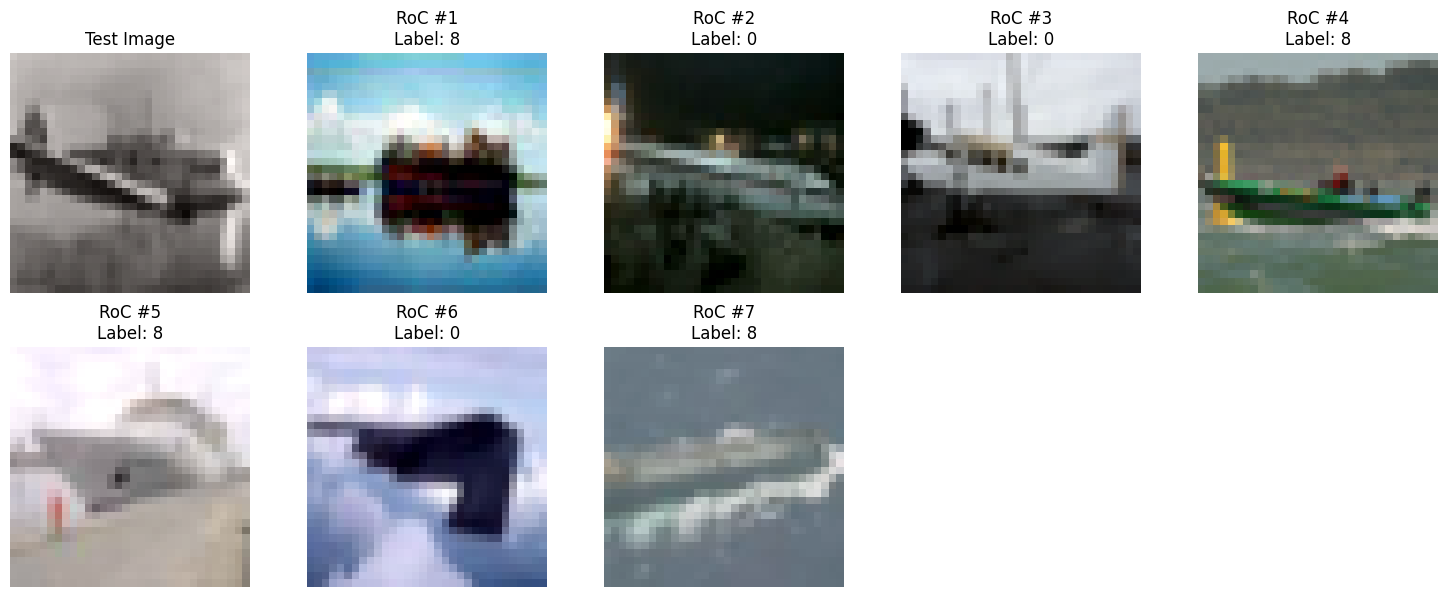

8

In [84]:
index = 16

print(f"True class: {test_set[index][1]}")

des_model.predict_weighted_robust_feature_similarity(test_set[index][0], explain=True) 

### Soft Voting 

In [35]:
def evaluate_soft(des_model, dataloader):
    total = 0
    correct = 0
    
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Testing SoftVoting"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # DES prediction (you can switch to robust or explainable prediction)
            preds = []
            for img in imgs:
                _, pred = des_model.predict_single_with_probs(
                    img
                )
                preds.append(pred)
            
            preds = torch.tensor(preds).to(device)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    acc = correct / total
    print(f"✅ Test Accuracy: {acc:.4f}")
    return acc

In [36]:
class SoftVotingEnsemble:
    def __init__(self, models, device='cpu'):
        self.models = models
        self.device = device
        for model in self.models:
            model.eval().to(device)

    def predict(self, images, return_probs=False):
        probs = []
        with torch.no_grad():
            for model in self.models:
                outputs = model(images.to(self.device))
                softmaxed = torch.softmax(outputs, dim=1)
                probs.append(softmaxed.cpu().numpy())
        mean_probs = np.mean(np.stack(probs), axis=0)
        if return_probs:
            return mean_probs
        return np.argmax(mean_probs, axis=1)

    def predict_single_with_probs(self, image):
        image = image.unsqueeze(0)  # Shape [1, C, H, W]
        with torch.no_grad():
            model_probs = []
            for model in self.models:
                logits = model(image.to(self.device))
                softmaxed = torch.softmax(logits, dim=1)
                model_probs.append(softmaxed.cpu().numpy())
            mean_probs = np.mean(np.stack(model_probs), axis=0)
            probs = mean_probs[0]
            pred = np.argmax(probs)
            return probs, pred

In [37]:
soft_model = SoftVotingEnsemble(trained_pool, device)

In [48]:
soft_model.predict_single_with_probs(test_set[0][0])

(array([9.9639308e-01, 9.4798699e-05, 2.9314775e-03, 8.6780834e-05,
        8.1010679e-05, 8.7768400e-05, 7.5646298e-05, 9.0376838e-05,
        9.8153389e-05, 6.0870989e-05], dtype=float32),
 0)

In [72]:
# =========================
# Run Test
# =========================
test_acc = evaluate_soft(soft_model, testloader)

Testing SoftVoting: 100%|███████████████████████████████████████████████| 10/10 [00:33<00:00,  3.35s/it]

✅ Test Accuracy: 0.9580


### Attack 

In [85]:
from torch.utils.data import TensorDataset, DataLoader
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from collections import defaultdict

In [86]:
print("Attacked")
TARGET_MODEL_INDEX = 2 
EPSILON = 0.05

target_model = trained_pool[TARGET_MODEL_INDEX]  
target_model = target_model.to(device).eval() 

dummy_optimizer = torch.optim.Adam(target_model.parameters())
loss_fn = nn.CrossEntropyLoss() 

# Wrap it for ART
art_classifier = PyTorchClassifier(
    model=target_model,
    loss=loss_fn,
    optimizer=dummy_optimizer,
    input_shape=(1, 32, 32),  
    nb_classes=10,
    clip_values=(0.0, 1.0),
)

x_test = []
y_test = []
    
for img, label in test_set: 
    x_test.append(img.numpy())
    y_test.append(label)
    
x_test = np.array(x_test)
y_test = np.array(y_test)

pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv = pgd_attack.generate(x=x_test) 

Attacked


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [87]:
adv_tensor = torch.tensor(x_test_adv).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset = TensorDataset(adv_tensor, labels_tensor)

adv_test_loader = DataLoader(adv_dataset, batch_size=1, shuffle=False)

In [88]:
evaluate_model_pool(trained_pool, adv_test_loader, device_name, model_names)

VGG19           → Accuracy: 89.60%, Loss: 0.4968
ResNet50        → Accuracy: 88.30%, Loss: 0.5916
DenseNet169     → Accuracy: 66.30%, Loss: 2.2778
MobileNetV2     → Accuracy: 87.50%, Loss: 0.5734
GoogleNet       → Accuracy: 89.30%, Loss: 0.4014


#### Double Attack 

In [89]:
print("Attacked")
TARGET_MODEL_INDEX = 4 
EPSILON = 0.05

target_model = trained_pool[TARGET_MODEL_INDEX]  
target_model = target_model.to(device).eval() 

dummy_optimizer = torch.optim.Adam(target_model.parameters())
loss_fn = nn.CrossEntropyLoss() 

# Wrap it for ART
art_classifier = PyTorchClassifier(
    model=target_model,
    loss=loss_fn,
    optimizer=dummy_optimizer,
    input_shape=(1, 32, 32),  
    nb_classes=10,
    clip_values=(0.0, 1.0),
)


pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_double = pgd_attack.generate(x=x_test_adv) 

Attacked


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [90]:
adv_tensor = torch.tensor(x_test_adv_double).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_double = TensorDataset(adv_tensor, labels_tensor)

adv_test_loader_double = DataLoader(adv_dataset_double, batch_size=1, shuffle=False)

In [91]:
evaluate_model_pool(trained_pool, adv_test_loader_double, device_name, model_names)

VGG19           → Accuracy: 87.00%, Loss: 0.6317
ResNet50        → Accuracy: 83.80%, Loss: 0.8774
DenseNet169     → Accuracy: 63.00%, Loss: 2.2720
MobileNetV2     → Accuracy: 82.00%, Loss: 0.8131
GoogleNet       → Accuracy: 56.30%, Loss: 2.8434


### Triple Attack 

In [92]:
print("Attacked")
TARGET_MODEL_INDEX = 0 
EPSILON = 0.05

target_model = trained_pool[TARGET_MODEL_INDEX]  
target_model = target_model.to(device).eval() 

dummy_optimizer = torch.optim.Adam(target_model.parameters())
loss_fn = nn.CrossEntropyLoss() 

# Wrap it for ART
art_classifier = PyTorchClassifier(
    model=target_model,
    loss=loss_fn,
    optimizer=dummy_optimizer,
    input_shape=(1, 32, 32),  
    nb_classes=10,
    clip_values=(0.0, 1.0),
)


pgd_attack = ProjectedGradientDescent(estimator=art_classifier, eps=EPSILON, eps_step=0.01, max_iter=100)
x_test_adv_triple = pgd_attack.generate(x=x_test_adv_double) 

Attacked


PGD - Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [93]:
adv_tensor = torch.tensor(x_test_adv_triple).float()
labels_tensor = torch.tensor(y_test).long()
adv_dataset_triple = TensorDataset(adv_tensor, labels_tensor)

adv_test_loader_triple = DataLoader(adv_dataset_triple, batch_size=1, shuffle=False)

In [94]:
evaluate_model_pool(trained_pool, adv_test_loader_triple, device_name, model_names)

VGG19           → Accuracy: 56.10%, Loss: 3.2449
ResNet50        → Accuracy: 76.00%, Loss: 1.3185
DenseNet169     → Accuracy: 58.60%, Loss: 2.5922
MobileNetV2     → Accuracy: 73.90%, Loss: 1.3008
GoogleNet       → Accuracy: 58.40%, Loss: 2.2859


### Test attacks 

In [95]:
# =========================
# Run Test
# =========================
test_acc = evaluate_soft(soft_model, adv_test_loader)

Testing SoftVoting: 100%|███████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.31it/s]

✅ Test Accuracy: 0.8890


In [96]:
# =========================
# Run Test
# =========================
# Assume `vision_des` is already created & trained
test_acc = evaluate_des(des_model, adv_test_loader)

Testing VisionDES: 100%|████████████████████████████████████████████| 1000/1000 [03:29<00:00,  4.77it/s]

✅ Test Accuracy: 0.9040


### Double Attack 

In [97]:
# =========================
# Run Test
# =========================
test_acc = evaluate_soft(soft_model, adv_test_loader_double) 

Testing SoftVoting: 100%|███████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.47it/s]

✅ Test Accuracy: 0.7960


In [98]:
# =========================
# Run Test
# =========================
# Assume `vision_des` is already created & trained
test_acc = evaluate_des(des_model, adv_test_loader_double)

Testing VisionDES: 100%|████████████████████████████████████████████| 1000/1000 [03:26<00:00,  4.85it/s]

✅ Test Accuracy: 0.8540


### Triple Attack

In [99]:
# =========================
# Run Test
# =========================
test_acc = evaluate_soft(soft_model, adv_test_loader_triple) 

Testing SoftVoting: 100%|███████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.52it/s]

✅ Test Accuracy: 0.6770


In [100]:
# =========================
# Run Test
# =========================
# Assume `vision_des` is already created & trained
test_acc = evaluate_des(des_model, adv_test_loader_triple)

Testing VisionDES: 100%|████████████████████████████████████████████| 1000/1000 [03:24<00:00,  4.90it/s]

✅ Test Accuracy: 0.7520
